# Comparação entre Abordagens de Visão Computacional (YOLOv5, YOLO Tradicional e CNN)  
### Referente à Entrega 2 do Projeto PBL - Fase 6


## Introdução

Nesta segunda entrega do Projeto PBL – Fase 6, realizamos uma análise comparativa entre diferentes abordagens de visão computacional aplicadas à tarefa de classificação/detecção de veículos (Carros e Motos).

As abordagens analisadas foram:

1. **YOLOv5 adaptado** (Entregue na Etapa 1) – modelo treinado com dataset customizado
2. **YOLOv5 tradicional** – modelo pré-treinado (sem re-treinamento)
3. **CNN desenvolvida do zero** – modelo de classificação simples construído e treinado do zero

O objetivo é comparar essas soluções com base em critérios como:
- Facilidade de uso e integração
- Precisão do modelo
- Tempo de treinamento
- Tempo de inferência

As imagens e rótulos utilizados são os mesmos da Entrega 1, com reorganização para atender aos requisitos de cada abordagem.


## Preparação

### Imports Iniciais

Nesta célula, são realizados os imports essenciais para execução do notebook, incluindo:

- Bibliotecas de sistema (`os`, `subprocess`, `glob`, `time`)
- Bibliotecas para verificação de hardware e uso de GPU (`torch`)
- Bibliotecas de visualização para análise dos resultados (`matplotlib`)
- Bibliotecas para manipulação de dados (`pandas`, `numpy`)

In [1]:
import os
import torch
import subprocess
import time
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from matplotlib.lines import Line2D
import pandas as pd
from IPython.display import FileLink

### Verificação do Ambiente e da GPU

Antes de iniciar o treinamento do modelo YOLOv5, é importante verificar se o ambiente está utilizando uma GPU. O uso de GPU é altamente recomendado, especialmente no Google Colab, pois acelera significativamente o processo de treinamento e evita possíveis interrupções por tempo limite.

> 💡 Este notebook pode ser executado tanto no **Google Colab** quanto **localmente**. A verificação abaixo ajuda a garantir que os recursos computacionais estão adequados antes de seguir.

In [2]:
# Função auxiliar para detectar se está no Colab
def esta_no_colab():
    return 'COLAB_GPU' in os.environ

# Verificação do ambiente
if esta_no_colab():
    print("🟢 Ambiente detectado: Google Colab")
else:
    print("💻 Ambiente detectado: Execução Local")

# Verificação de GPU
if torch.cuda.is_available():
    device_name = torch.cuda.get_device_name(0)
    print(f"\033[92m✅ GPU disponível:\033[0m {device_name}")
    print("O ambiente está configurado corretamente para o treinamento.")
else:
    print("\033[91m❌ ATENÇÃO: GPU não disponível. O notebook está executando em CPU.\033[0m\n")
    print("❗ O treinamento com YOLOv5 em CPU pode ser extremamente lento e sujeito a interrupções por tempo limite.\n")
    
    if esta_no_colab():
        print("\033[1mRecomendações para ativar GPU no Colab:\033[0m")
        print("- Vá até o menu 'Ambiente de execução > Alterar tipo de ambiente de execução'")
        print("- Selecione 'GPU' como acelerador de hardware e clique em 'Salvar'")
        print("- O ambiente será reiniciado. Após a reinicialização, reexecute esta célula antes de continuar.")


💻 Ambiente detectado: Execução Local
✅ GPU disponível: NVIDIA GeForce RTX 3060 Laptop GPU
O ambiente está configurado corretamente para o treinamento.


### Conexão com o Google Drive ou Ambiente Local

Nesta etapa, o notebook verifica automaticamente se está sendo executado no Google Colab ou em ambiente local. Em seguida, realiza a montagem do Google Drive (caso Colab) e define os caminhos apropriados para acessar o dataset e o arquivo de configuração `.yaml` do YOLOv5.

Isso garante que o notebook funcione de forma flexível, independentemente do ambiente de execução.

In [3]:
try:
    from google.colab import drive
    print("✅ Executando no Google Colab")

    # Monta o Google Drive se necessário
    drive_path = "/content/drive"
    mydrive_path = os.path.join(drive_path, "MyDrive")
    if not os.path.exists(mydrive_path):
        print("🔄 Google Drive não está montado. Montando agora...")
        drive.mount(drive_path)
    else:
        drive.mount(drive_path, force_remount=True)
        print("✅ Google Drive já está montado.")

    # Caminho no Google Drive
    dataset_dir = os.path.join(mydrive_path, "1TIAOR20242_FASE6_CAP1")
    yaml_filename = "veiculos.yaml"
    pathConfiguration = os.path.join(dataset_dir, "configuration", yaml_filename)

except ImportError:
    print("✅ Executando localmente")

    # Caminho local padrão
    dataset_dir = os.path.abspath("../")
    yaml_filename = "veiculos_local.yaml"
    pathConfiguration = os.path.join(dataset_dir, "configuration", yaml_filename)

    # Se não encontrar, tenta um nível acima
    if not os.path.exists(pathConfiguration):
        dataset_dir = os.path.abspath("../../")
        pathConfiguration = os.path.join(dataset_dir, "configuration", yaml_filename)

# Validação final
if not os.path.exists(pathConfiguration):
    raise FileNotFoundError(f"Arquivo não encontrado: {pathConfiguration}")

# Exibe os caminhos definidos
print(f"Caminho dos Datasets: {dataset_dir}")
print(f"Arquivo de configuração: {pathConfiguration}")


✅ Executando localmente
Caminho dos Datasets: /home/joseandre/fiap_projetos/1TIAOR20242_FASE6_CAP1
Arquivo de configuração: /home/joseandre/fiap_projetos/1TIAOR20242_FASE6_CAP1/configuration/veiculos_local.yaml


### Referência: Resultado da Entrega 1 (YOLOv5 Adaptado - 60 épocas)


### 📌 Referência: Resultado da Entrega 1 (YOLOv5 Adaptado – 60 Épocas)

A célula abaixo extrai diretamente as métricas de desempenho do modelo treinado na Entrega 1 (60 épocas), utilizando o arquivo `results.csv` gerado pelo YOLOv5.

In [4]:
import pandas as pd

# Carrega o CSV com os resultados
results_path = 'yolov5/runs/train/veiculos_yolo_60ep/results.csv'
df = pd.read_csv(results_path)
df.columns = df.columns.str.strip()  # limpa espaços

# Última linha = última época
ultima_epoca = df.iloc[-1]

# Exibe métricas principais
print("📊 Desempenho do YOLOv5 Adaptado – 60 Épocas:")
print(f"✔️ Precisão       : {ultima_epoca['metrics/precision']:.4f}")
print(f"✔️ Recall          : {ultima_epoca['metrics/recall']:.4f}")
print(f"✔️ mAP@0.5         : {ultima_epoca['metrics/mAP_0.5']:.4f}")
print(f"✔️ mAP@0.5:0.95    : {ultima_epoca['metrics/mAP_0.5:0.95']:.4f}")


📊 Desempenho do YOLOv5 Adaptado – 60 Épocas:
✔️ Precisão       : 0.9652
✔️ Recall          : 0.9963
✔️ mAP@0.5         : 0.9950
✔️ mAP@0.5:0.95    : 0.7835


#### 📈 Métricas Finais - YOLOv5 Adaptado (60 Épocas)

- **Precisão (`precision`)**: 0.9652  
- **Recall (`recall`)**: 0.9963  
- **mAP@0.5**: 0.9950  
- **mAP@0.5:0.95**: 0.7835

Esses resultados reforçam que o modelo treinado com 60 épocas teve excelente desempenho, tanto em termos de cobertura (recall) quanto de acurácia nas detecções.


## 🔍 YOLOv5 Tradicional

### 📷 Inferência com Modelo Pré-Treinado (yolov5s.pt)

Nesta etapa, realizamos a inferência usando o modelo YOLOv5 padrão (pré-treinado pela Ultralytics, `yolov5s.pt`) diretamente no conjunto de teste, sem re-treinamento com os dados do projeto.

O objetivo é comparar qualitativamente o desempenho desse modelo com o modelo adaptado na Entrega 1.

In [5]:
nome_treinamento = "yolo_tradicional"

# Parâmetros utilizados:
# --weights: define o modelo YOLOv5 a ser utilizado (pré-treinado 'yolov5s.pt')
# --img: tamanho da imagem de entrada (640x640 pixels)
# --conf: nível mínimo de confiança para considerar uma detecção
# --source: diretório com as imagens do conjunto de teste
# --name: nome da pasta onde os resultados da inferência serão salvos (dentro de runs/detect/)
# --exist-ok: permite sobrescrever a pasta de saída se ela já existir

# Marca o início da execução
inicio = time.time()

# Executa a inferência com o modelo pré-treinado
!python yolov5/detect.py \
  --weights yolov5s.pt \
  --img 640 \
  --conf 0.25 \
  --source {dataset_dir}/dataset_images/images/test \
  --name {nome_treinamento}_test \
  --exist-ok

# Marca o fim da execução e calcula a duração
fim = time.time()
print(f"Tempo de inferência com YOLO pré-treinado: {fim - inicio:.2f} segundos")


detect: weights=['yolov5s.pt'], source=/home/joseandre/fiap_projetos/1TIAOR20242_FASE6_CAP1/dataset_images/images/test, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=yolo_tradicional_test, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-416-gfe1d4d99 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
image 1/8 /home/joseandre/fiap_projetos/1TIAOR20242_FASE6_CAP1/dataset_images/images/test/Imagem073.jpg: 480x640 3 cars, 1 motorcycle, 46.5ms
image 2/8 /home/joseandre/fiap_projetos/1TIAOR20242_FASE6_CAP1/dataset_ima

### Visualização dos resultados da YOLOv5 Tradicional

Abaixo estão algumas imagens do conjunto de teste processadas pelo modelo pré-treinado YOLOv5s. O objetivo é observar quais objetos foram detectados, como foram classificados e se há consistência nas detecções para as classes de interesse (carro e moto).


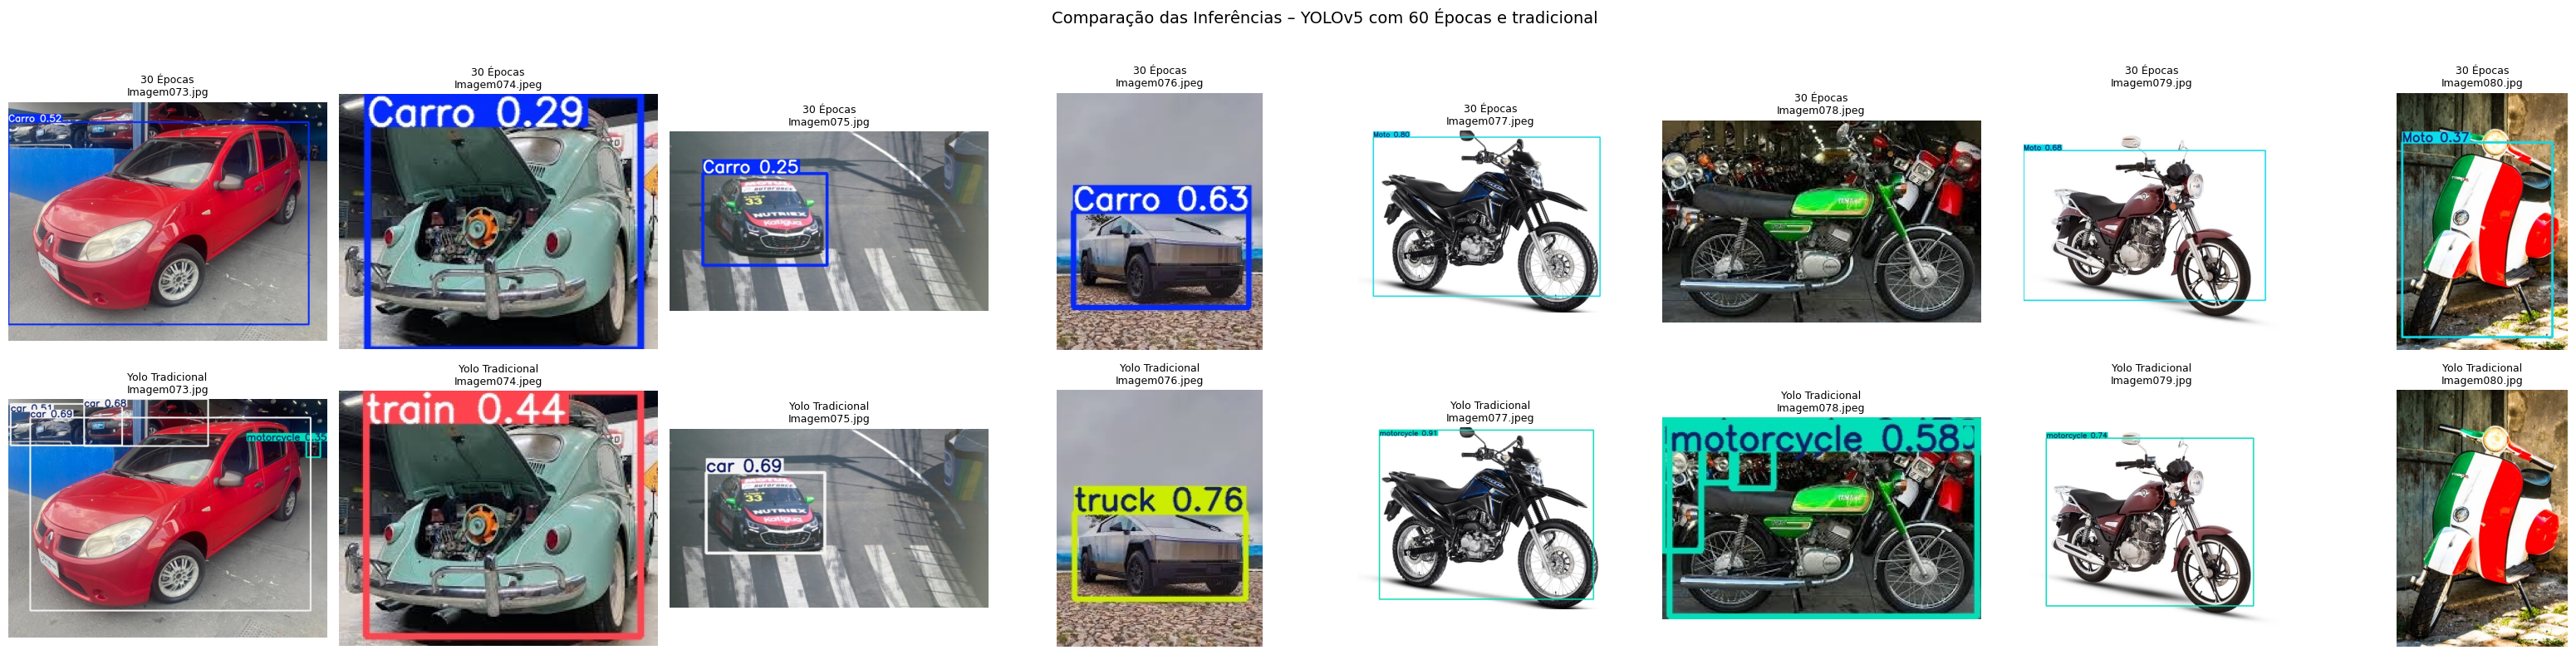

In [6]:
# Diretórios de saída
dir_60 = f'yolov5/runs/detect/veiculos_yolo_60ep_test'
dir_tradicional = f'yolov5/runs/detect/yolo_tradicional_test'

def get_images(folder, n=8):
    exts = ('*.jpg','*.jpeg','*.png','*.bmp')
    imgs = []
    for e in exts:
        imgs += glob.glob(os.path.join(folder, e))
    return sorted(imgs)[:n]

# Lista de imagens detectadas (as mesmas usadas nos testes)
imgs_60 = get_images(dir_60)
imgs_tradicional = get_images(dir_tradicional)

# Número máximo de imagens
num_imgs = min(8, len(imgs_60), len(imgs_tradicional))

fig, axes = plt.subplots(2, num_imgs, figsize=(num_imgs * 4, 8))

for i in range(num_imgs):
    # Linha 0 = 30 épocas
    img30 = mpimg.imread(imgs_60[i])
    axes[0, i].imshow(img30)
    axes[0, i].set_title(f'30 Épocas\n{os.path.basename(imgs_60[i])}', fontsize=9)
    axes[0, i].axis('off')

    # Linha 1 = 60 épocas
    img60 = mpimg.imread(imgs_tradicional[i])
    axes[1, i].imshow(img60)
    axes[1, i].set_title(f'Yolo Tradicional\n{os.path.basename(imgs_tradicional[i])}', fontsize=9)
    axes[1, i].axis('off')

plt.suptitle("Comparação das Inferências – YOLOv5 com 60 Épocas e tradicional", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # espaço para o título
plt.show()



### Análise de desempenho do modelo YOLOv5 Tradicional (Pré-treinado)


Ao aplicar o modelo YOLOv5s pré-treinado (sem re-treinamento) sobre as imagens do conjunto de teste, foram observadas as seguintes características e comportamentos:

#### 🔹 Detecções realizadas
- O modelo foi capaz de detectar **carros** e **motos**, que são classes presentes no dataset COCO (base de treinamento do YOLOv5 pré-treinado).
- Em algumas imagens, foi capaz de detectar **mais de um objeto da mesma classe**, como múltiplos carros ou motos, demonstrando uma boa capacidade de identificação em ambientes com múltiplas ocorrências.
- Algumas imagens apresentaram **detecções incorretas ou irrelevantes**, como a classificação de "train" ou "truck", indicando limitações no foco da aplicação.

#### 🔹 Acertos e limitações por imagem
- **Imagem 073**: Detecção de 3 carros e 1 moto, indicando boa sensibilidade.
- **Imagem 074**: Detecção incorreta como "train", devido à vista traseira incomum do fusca.
- **Imagem 075**: Detecção correta de um carro.
- **Imagem 076**: Detecção como "truck" (possivelmente confundido com o design do Tesla Cybertruck).
- **Imagem 077**: Detecção correta de uma moto.
- **Imagem 078**: Detecção de 4 motos, indicando alta sensibilidade, mas possível excesso.
- **Imagem 079**: Detecção correta de uma moto.
- **Imagem 080**: Nenhuma detecção (moto tipo Vespa, possivelmente fora do padrão aprendido).

#### 🔹 Tempo de inferência
- O tempo total de inferência foi de aproximadamente **7,17 segundos** para processar as 8 imagens do conjunto de teste.
- A média de tempo por imagem foi de aproximadamente **23,8 ms de inferência** e **18,7 ms de NMS**, o que representa uma performance adequada para aplicações em tempo real ou embarcadas.

#### 🔹 Robustez e generalização
- O modelo demonstrou **capacidade de generalizar** bem para contextos diversos, sendo capaz de detectar objetos mesmo em imagens não padronizadas.
- A presença de falsos positivos e detecções de classes fora do escopo do projeto reforça o caráter **genérico** do modelo.

Esses resultados demonstram que o modelo YOLOv5 pré-treinado, mesmo sem ajustes, consegue fornecer **resultados relevantes** em ambientes variados, desde que as classes estejam contempladas em seu conjunto de treinamento original.


### Conclusão parcial – YOLOv5 Tradicional (Pré-treinado)

O modelo YOLOv5s pré-treinado, utilizado sem re-treinamento, apresentou um desempenho satisfatório ao ser aplicado diretamente sobre as imagens do conjunto de teste do projeto.

Mesmo sem ter sido treinado com o dataset específico, o modelo foi capaz de detectar corretamente diversas ocorrências das classes "car" e "motorcycle", mostrando uma boa generalização para objetos presentes em seu dataset original (COCO).

Além disso, o modelo demonstrou:
- **Capacidade de identificar múltiplos objetos por imagem**, o que é relevante em ambientes complexos.
- **Tempo de inferência adequado** (7,84 segundos para 8 imagens), tornando-o viável para aplicações práticas.
- **Alguns falsos positivos ou classificações irrelevantes**, como "train" e "truck", esperados em um modelo genérico.

Por outro lado, a detecção incorreta de objetos incomuns (como o Tesla Cybertruck ou a traseira aberta de um fusca) e a ausência de detecção em casos menos padronizados (como a moto Vespa) indicam **limitações relacionadas à representatividade do dataset de origem** e à falta de especialização no domínio do projeto.

Em resumo, o YOLO pré-treinado é uma ferramenta prática e eficaz para uso geral, oferecendo bons resultados iniciais mesmo sem personalização. No entanto, **pode não atender com a precisão exigida em contextos específicos**, como os esperados por um cliente com necessidades claramente definidas.


## 2. Classificação com CNN do Zero (Carro vs Moto)



Nesta etapa, será implementada uma rede neural convolucional simples, treinada do zero para classificar imagens entre duas categorias: "carro" e "moto".

Diferente do modelo YOLO, que realiza detecção de objetos, a CNN será responsável apenas pela **classificação da imagem como um todo**, com base em características visuais.

Para isso, utilizaremos as mesmas imagens da Entrega 1, reestruturando o dataset para seguir o padrão esperado por bibliotecas como `ImageDataGenerator` (Keras) ou `ImageFolder` (PyTorch).

A estrutura esperada do diretório de dados é a seguinte:

```
📦 1TIAOR20242_FASE6_CAP1
│── 📁 dataset_cnn           # Pasta principal para classificação com CNN
│   ├── 📁 train             # Imagens utilizadas para o treinamento (64 imagens por classe)
│   │   ├── 📁 carro         # Imagens da classe "carro"
│   │   ├── 📁 moto          # Imagens da classe "moto"
│   ├── 📁 val               # Imagens utilizadas para validação (8 imagens por classe)
│   │   ├── 📁 carro         # Imagens da classe "carro"
│   │   ├── 📁 moto          # Imagens da classe "moto"
│   ├── 📁 test              Imagens utilizadas para avaliação final (8 imagens por classe)
│   │   ├── 📁 carro         # Imagens da classe "carro"
│   │   ├── 📁 moto          # Imagens da classe "moto"
```

Com essa organização, é possível carregar as imagens automaticamente com os respectivos rótulos, simplificando o processo de preparação do dataset para a CNN.

### Verificação e montagem do Google Drive

Antes de carregar o dataset da CNN, verificamos se o Google Drive está montado no ambiente do Google Colab.

Essa etapa é essencial, pois o ambiente pode ter sido reiniciado e a conexão com o Drive perdida desde a execução da Entrega 1.


In [7]:
import os

# Verifica se o ambiente é Google Colab ou local
try:
    # Verifica se está no Google Colab
    from google.colab import drive
    print("✅ Executando no Google Colab")

    # Verifica se o Google Drive já está montado
    if not os.path.exists('/content/drive/MyDrive'):
        print("🔄 Google Drive não está montado. Montando agora...")
        drive.mount('/content/drive')
    else:
        drive.mount('/content/drive', force_remount=True)
        print("✅ Google Drive já está montado.")

    # Caminho no Google Drive
    dataset_dir = "/content/drive/MyDrive/1TIAOR20242_FASE6_CAP1/dataset_cnn"

except ImportError:
    # Caso não esteja no Colab, executa localmente
    print("✅ Executando localmente")

    # Caminho local
    dataset_dir = os.path.abspath("../dataset_cnn")

# Exemplo de uso do caminho
print(f"Caminho dos Datasets: {dataset_dir}")

✅ Executando localmente
Caminho dos Datasets: /home/joseandre/fiap_projetos/1TIAOR20242_FASE6_CAP1/dataset_cnn


### Carregamento do dataset a partir do Google Drive

Com o dataset já estruturado na pasta `dataset_cnn` dentro do Google Drive, vamos utilizar a biblioteca `ImageDataGenerator` da Keras para carregar e preparar os dados para treinamento, validação e teste.

O carregamento será feito com base na estrutura de subpastas (`carro/` e `moto/`) já organizadas dentro dos diretórios `train`, `val` e `test`.

O caminho completo do dataset no Google Drive deve ser:
```
/content/drive/MyDrive/1TIAOR20242_FASE6_CAP1/dataset_cnn/
```

Cada subpasta dentro de `train/`, `val/` e `test/` representa o rótulo da classe correspondente.

In [8]:
import os

# Função para validar as subpastas
def validar_subpastas(dataset_dir):
    subpastas_necessarias = ['test', 'val', 'train']
    subpastas_existentes = os.listdir(dataset_dir) if os.path.exists(dataset_dir) else []

    # Verifica se todas as subpastas necessárias estão presentes
    subpastas_faltando = [pasta for pasta in subpastas_necessarias if pasta not in subpastas_existentes]

    if subpastas_faltando:
        print("\033[91m❌ ERRO: As seguintes subpastas estão faltando no diretório:\033[0m")
        for pasta in subpastas_faltando:
            print(f"  - {pasta}")
        print("\033[93m⚠️ Verifique o caminho do dataset e a estrutura esperada.\033[0m")
    else:
        print("\033[92m✅ Todas as subpastas necessárias estão presentes:\033[0m")
        for pasta in subpastas_necessarias:
            print(f"  - {pasta}")

# Valida as subpastas
validar_subpastas(dataset_dir)

✅ Todas as subpastas necessárias estão presentes:
  - test
  - val
  - train


In [9]:
import os
import sys
import warnings
import contextlib
import time
from keras.saving import save_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Input
import pandas as pd



2025-04-21 04:23:26.800326: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 04:23:26.922733: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-21 04:23:28.070047: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [10]:
# Tamanhos e parâmetros
image_size = (224, 224)
batch_size = 16

# Pré-processamento básico: reescala os pixels para o intervalo [0, 1]
datagen = ImageDataGenerator(rescale=1./255)

# Carregamento dos dados
train_generator = datagen.flow_from_directory(
    directory=f"{dataset_dir}/train",
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'  # classificação binária
)

val_generator = datagen.flow_from_directory(
    directory=f"{dataset_dir}/val",
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = datagen.flow_from_directory(
    directory=f"{dataset_dir}/test",
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # importante para avaliação
)

Found 64 images belonging to 2 classes.
Found 8 images belonging to 2 classes.
Found 8 images belonging to 2 classes.


### Separação

In [11]:
@contextlib.contextmanager
def ocultar_output():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr


def criar_modelo():
    model = Sequential([
        Input(shape=(224, 224, 3)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

def treino_silencioso(model, train_gen, val_gen, epochs, nome_modelo):
    print(f"\n🚀 Iniciando treinamento: {nome_modelo} ({epochs} épocas)")
    inicio = time.time()

    with ocultar_output():
        history = model.fit(train_gen, validation_data=val_gen, epochs=epochs, verbose=0)

    fim = time.time()
    duracao = fim - inicio
    print(f"✅ Treinamento finalizado: {nome_modelo} | ⏱️ Tempo: {duracao:.2f} segundos")
    return history


# Treinar CNN com 30 épocas
model_30 = criar_modelo()
history_30 = treino_silencioso(model_30, train_generator, val_generator, 30, "CNN - 30 Épocas")

# Treinar CNN com 60 épocas
model_60 = criar_modelo()
history_60 = treino_silencioso(model_60, train_generator, val_generator, 60, "CNN - 60 Épocas")

save_model(model_30, "../models/cnn_30ep.keras")
save_model(model_60, "../models/cnn_60ep.keras")

print("💾 Modelos salvos: cnn_30ep.h5 e cnn_60ep.h5")




🚀 Iniciando treinamento: CNN - 30 Épocas (30 épocas)


2025-04-21 04:23:29.271534: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-21 04:23:29.279564: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


✅ Treinamento finalizado: CNN - 30 Épocas | ⏱️ Tempo: 45.41 segundos

🚀 Iniciando treinamento: CNN - 60 Épocas (60 épocas)
✅ Treinamento finalizado: CNN - 60 Épocas | ⏱️ Tempo: 90.10 segundos
💾 Modelos salvos: cnn_30ep.h5 e cnn_60ep.h5


In [12]:
def gerar_tabela_comparativa(history_30, history_60, model_30, model_60):
    from sklearn.metrics import classification_report

    # Classes reais e nomes das classes
    y_true = test_generator.classes
    class_names = list(test_generator.class_indices.keys())

    # Predições
    y_pred_30 = (model_30.predict(test_generator, verbose=0) > 0.5).astype(int).ravel()
    y_pred_60 = (model_60.predict(test_generator, verbose=0) > 0.5).astype(int).ravel()

    # Reports
    report_30 = classification_report(y_true, y_pred_30, target_names=class_names, output_dict=True)
    report_60 = classification_report(y_true, y_pred_60, target_names=class_names, output_dict=True)

    # Montar DataFrame comparativo
    comparativo = pd.DataFrame({
        "CNN - 30 Épocas": {
            "accuracy": report_30["accuracy"],
            f"precision_{class_names[0]}": report_30[class_names[0]]["precision"],
            f"recall_{class_names[0]}": report_30[class_names[0]]["recall"],
            f"f1_{class_names[0]}": report_30[class_names[0]]["f1-score"],
            f"precision_{class_names[1]}": report_30[class_names[1]]["precision"],
            f"recall_{class_names[1]}": report_30[class_names[1]]["recall"],
            f"f1_{class_names[1]}": report_30[class_names[1]]["f1-score"]
        },
        "CNN - 60 Épocas": {
            "accuracy": report_60["accuracy"],
            f"precision_{class_names[0]}": report_60[class_names[0]]["precision"],
            f"recall_{class_names[0]}": report_60[class_names[0]]["recall"],
            f"f1_{class_names[0]}": report_60[class_names[0]]["f1-score"],
            f"precision_{class_names[1]}": report_60[class_names[1]]["precision"],
            f"recall_{class_names[1]}": report_60[class_names[1]]["recall"],
            f"f1_{class_names[1]}": report_60[class_names[1]]["f1-score"]
        }
    })

    return comparativo.round(3).T


# Exibir a tabela
comparativo_df = gerar_tabela_comparativa(history_30, history_60, model_30, model_60)
display(comparativo_df)

,accuracy,precision_carro,recall_carro,f1_carro,precision_moto,recall_moto,f1_moto
CNN - 30 Épocas,0.750,0.750,0.75,0.750,0.75,0.75,0.750
CNN - 60 Épocas,0.625,0.667,0.50,0.571,0.60,0.75,0.667


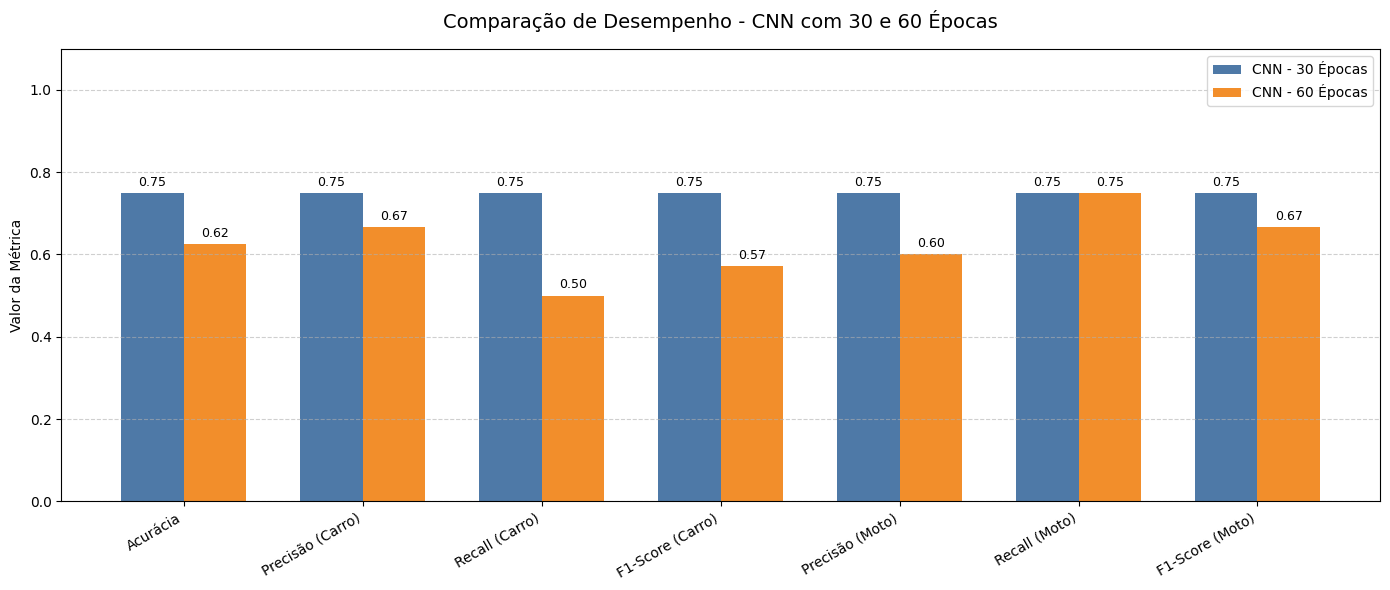

In [13]:
# Dados
metricas = comparativo_df.columns.tolist()
modelo_30 = comparativo_df.loc["CNN - 30 Épocas"].values
modelo_60 = comparativo_df.loc["CNN - 60 Épocas"].values
x = np.arange(len(metricas))
width = 0.35

# Rótulos legíveis
metricas_formatadas = [
    "Acurácia",
    "Precisão (Carro)", "Recall (Carro)", "F1-Score (Carro)",
    "Precisão (Moto)", "Recall (Moto)", "F1-Score (Moto)"
]

# Gráfico
fig, ax = plt.subplots(figsize=(14, 6))
bars1 = ax.bar(x - width/2, modelo_30, width, label='CNN - 30 Épocas', color='#4E79A7')
bars2 = ax.bar(x + width/2, modelo_60, width, label='CNN - 60 Épocas', color='#F28E2B')

# Estética
ax.set_ylabel('Valor da Métrica')
ax.set_title('Comparação de Desempenho - CNN com 30 e 60 Épocas', fontsize=14, pad=15)
ax.set_xticks(x)
ax.set_xticklabels(metricas_formatadas, rotation=30, ha='right')
ax.set_ylim(0, 1.1)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.6)

# Adiciona valores nas barras
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()

# Salvar como imagem (opcional)
# plt.savefig("grafico_comparativo_cnn.png", dpi=300)


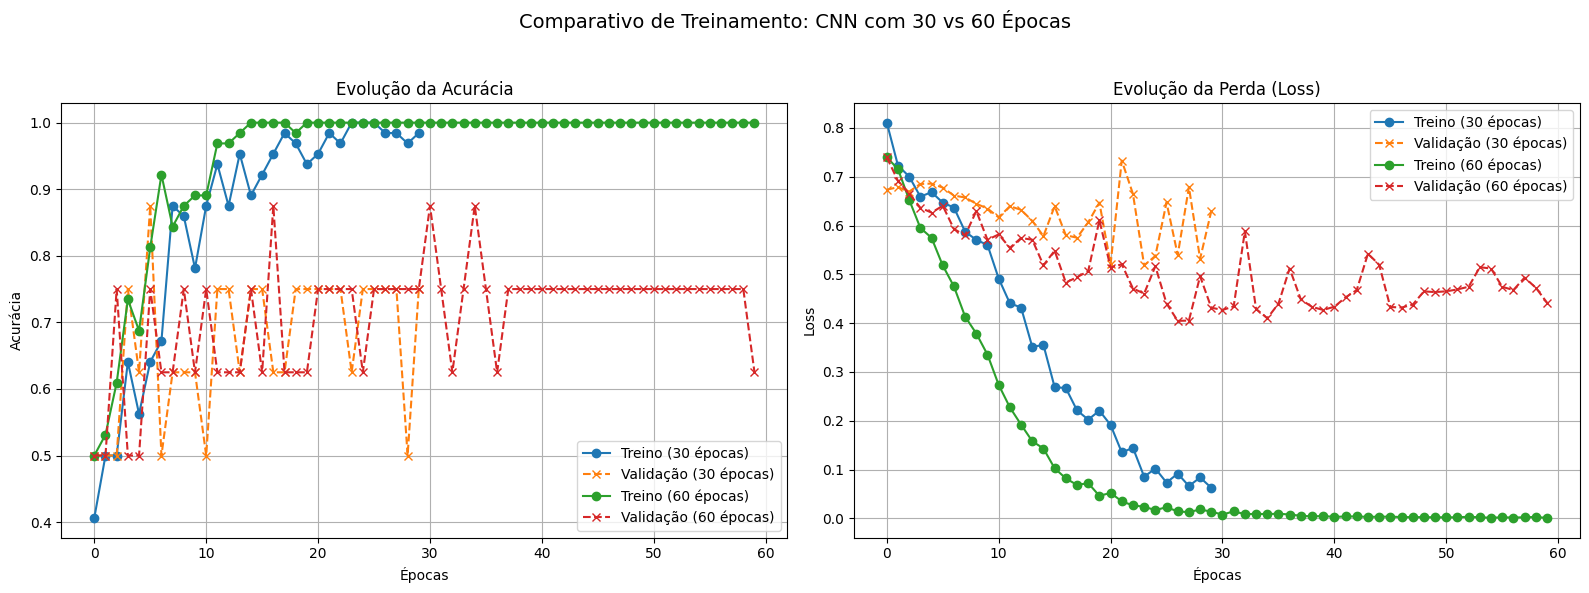

In [14]:
def comparar_historicos(history_30, history_60):
    plt.figure(figsize=(16, 6))

    # Gráfico de Acurácia
    plt.subplot(1, 2, 1)
    plt.plot(history_30.history['accuracy'], label='Treino (30 épocas)', linestyle='-', marker='o')
    plt.plot(history_30.history['val_accuracy'], label='Validação (30 épocas)', linestyle='--', marker='x')
    plt.plot(history_60.history['accuracy'], label='Treino (60 épocas)', linestyle='-', marker='o')
    plt.plot(history_60.history['val_accuracy'], label='Validação (60 épocas)', linestyle='--', marker='x')
    plt.title("Evolução da Acurácia")
    plt.xlabel("Épocas")
    plt.ylabel("Acurácia")
    plt.grid(True)
    plt.legend()

    # Gráfico de Perda (Loss)
    plt.subplot(1, 2, 2)
    plt.plot(history_30.history['loss'], label='Treino (30 épocas)', linestyle='-', marker='o')
    plt.plot(history_30.history['val_loss'], label='Validação (30 épocas)', linestyle='--', marker='x')
    plt.plot(history_60.history['loss'], label='Treino (60 épocas)', linestyle='-', marker='o')
    plt.plot(history_60.history['val_loss'], label='Validação (60 épocas)', linestyle='--', marker='x')
    plt.title("Evolução da Perda (Loss)")
    plt.xlabel("Épocas")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    plt.suptitle("Comparativo de Treinamento: CNN com 30 vs 60 Épocas", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


comparar_historicos(history_30, history_60)
